# Investigating the vanishing feature phenomenon in linear networks

This notebook contains the implementation of investigating the vanishing feature phenomenon in linear networks reported in Section 3.3 of our paper.

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.utils.connect import interpolate_state_dicts
from source.utils.data_funcs import load_data
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from copy import deepcopy
from source.utils.logger import Logger
from source.utils.weight_matching import get_wm_perm, permutation_spec_from_axes_to_perm, PermutationSpec, apply_permutation
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/xingyu/anaconda3/envs/cpal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MLP(nn.Module):
    def __init__(self, in_channels=1, use_bias=True, num_classes=10, num_layers=4, w=16):
        super().__init__()
        self.w = w
        self.num_layers = num_layers
        # use a loop to create attributes called self.fc0, 1, 2, 3, ...
        for i in range(self.num_layers-1):
            setattr(self, f'fc{i}', nn.Linear(self.w if i > 0 else in_channels*28*28, self.w, bias=use_bias))
            # setattr(self, f'relu{i}', nn.ReLU())
        setattr(self, f'fc{self.num_layers-1}', nn.Linear(self.w, num_classes, bias=use_bias))
        
        for m in self.modules():
            if isinstance(m, (nn.Linear)):
                nn.init.normal_(m.weight, 0, 0.002)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, input, out_layer_id=None):
        
        out = input.view(input.size(0), -1)
        for i in range(self.num_layers-1):
            out = getattr(self, f'fc{i}')(out)
            if out_layer_id == i:
                return out
            # out = getattr(self, f'relu{i}')(out)
        out = getattr(self, f'fc{self.num_layers-1}')(out)
        return out

    def forward_hook(self, layer_name, pre_act=False):
        def hook(module, input, output):
            self.selected_out[layer_name] = input[0] if pre_act else output
        return hook

    def record(self, intermediate_layers, pre_act=False):
        """Record the output of intermediate layers."""
        self.intermediate_layers = intermediate_layers
        self.fhooks = []
        self.selected_out = {}
        self.params = dict(self.named_modules())
        for layer_name in self.intermediate_layers:
            fhook = self.params[layer_name].register_forward_hook(
                self.forward_hook(layer_name, pre_act))
            self.fhooks.append(fhook)
        return self

    def stop_record(self):
        """Stop recording the output of intermediate layers."""
        # Remove hooks
        for fhook in self.fhooks:
            fhook.remove()
        del self.intermediate_layers, self.fhooks, self.selected_out
        return self

In [4]:
def mlp_permutation_spec(num_hidden_layers: int, bias=True) -> PermutationSpec:
    """We assume that one permutation cannot appear in two axes of the same
    weight array."""
    assert num_hidden_layers >= 1
    if bias:
        bias_hidden = {f"fc{i}.bias": (f"P_{i}", )
                       for i in range(num_hidden_layers)}
        bias_last = {f"fc{num_hidden_layers}.bias": (None, )}
    else:
        bias_hidden, bias_last = {}, {}

    return permutation_spec_from_axes_to_perm({
        "fc0.weight": ("P_0", None),
        **{f"fc{i}.weight": (f"P_{i}", f"P_{i-1}")
           for i in range(1, num_hidden_layers)},
        **bias_hidden,
        f"fc{num_hidden_layers}.weight": (None, f"P_{num_hidden_layers-1}"),
        **bias_last,
    })

In [5]:
from source.utils.utils import AverageMeter, ProgressMeter, \
    Summary, accuracy
import time
def train(train_loader, model, criterion, optimizer,
          epoch, device, sampler, config, scheduler=None):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (data, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        data = data.to(device)
        target = target.to(device)

        # compute output
        output_full = model(data)
        loss_full = criterion(output_full, target)
        counter = 1

        loss_od = torch.tensor(0.).to(device)

        loss = loss_full + loss_od
        loss /= counter

        # measure accuracy and record loss
        acc1 = accuracy(output_full, target, topk=(1,))
        losses.update(loss_full.item(), data.size(0))
        top1.update(acc1[0].item(), data.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % config.print_freq == 0:
            progress.display(i + 1)
    return losses.avg, top1.avg, batch_time.avg


def validate(val_loader, model, criterion, device, config):

    def run_validate(loader, base_progress=0):
        with torch.no_grad():
            end = time.time()
            for i, (data, target) in enumerate(loader):
                i = base_progress + i
                data = data.to(device)
                target = target.to(device)

                # compute output
                output = model(data)
                loss = criterion(output, target)

                # measure accuracy and record loss
                acc1 = accuracy(output, target, topk=(1,))
                losses.update(loss.item(), data.size(0))
                top1.update(acc1[0].item(), data.size(0))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                if i % config.print_freq == 0:
                    progress.display(i + 1)

    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    losses = AverageMeter('Loss', ':.4e', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1],
        prefix='Test: ')

    if config.model == 'simple_mlp':
        criterion = nn.MSELoss()

    # switch to evaluate mode
    model.eval()

    run_validate(val_loader)

    progress.display_summary()

    return losses.avg, top1.avg, batch_time.avg

In [6]:
Logger.setup_logging()
logger = Logger()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class config:
    model = 'mlp'
    print_freq = 100
    path = '../data' # path to dataset

In [8]:
trainset, testset = load_data(config.path, 'mnist')
idx_train = (trainset.targets == 0) | (trainset.targets == 1)
idx_test = (testset.targets == 0) | (testset.targets == 1)

In [9]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

In [10]:
use_bias = True
num_classes = 10
num_layers = 8
w = 32
model_1, model_2 = MLP(1, use_bias, num_classes, num_layers=num_layers, w=w).to(device), MLP(1, use_bias, num_classes, num_layers=num_layers, w=w).to(device)
criterion = nn.CrossEntropyLoss()

#### Training 

This part can be skipped if only want to replicate the plots in the paper using our pre-trained models.

In [11]:
optimizer_1, optimizer_2 = torch.optim.Adam(model_1.parameters(), lr=0.01, weight_decay=1e-4), torch.optim.Adam(model_2.parameters(), lr=0.01, weight_decay=1e-4)

In [12]:
loss_s = [[], []]
acc_s = [[], []]

In [31]:
for epoch in range(5):
    loss_1, acc_1, _ = train(trainloader, model_1, criterion, optimizer_1, epoch, device, None, config)
    loss_2, acc_2, _ = train(trainloader, model_2, criterion, optimizer_2, epoch, device, None, config)
    loss_s[0].append(loss_1)
    loss_s[1].append(loss_2)
    acc_s[0].append(acc_1)
    acc_s[1].append(acc_2)
    

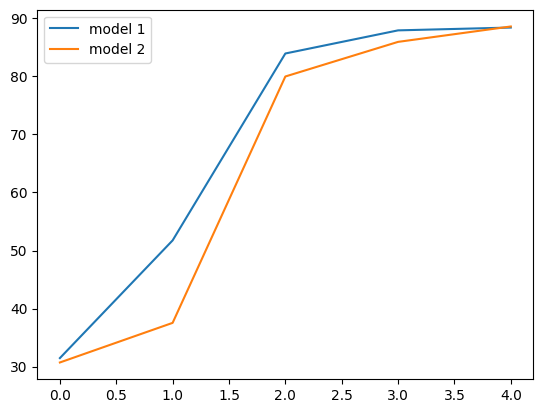

In [15]:
plt.plot(acc_s[0], label='model 1')
plt.plot(acc_s[1], label='model 2')
plt.legend()

In [16]:
import os

dir_path = '../checkpoints/linear_mlp/'
os.makedirs(dir_path, exist_ok=True)
torch.save(model_1.state_dict(), dir_path + 'model_1.pth')
torch.save(model_2.state_dict(), dir_path + 'model_2.pth')

#### Measure the vanishing feature

In [14]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

In [15]:
sd_1 = torch.load('../checkpoints/linear_mlp/model_1.pth', weights_only=True)
sd_2 = torch.load('../checkpoints/linear_mlp/model_2.pth', weights_only=True)

model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)

<All keys matched successfully>

In [16]:
sd_mid = interpolate_state_dicts(model_1.state_dict(), model_2.state_dict(), 0.5)
model_mid = MLP(1, use_bias, num_classes, num_layers=num_layers, w=w).to(device)
model_mid.load_state_dict(sd_mid)
validate(testloader, model_mid, criterion, device, config)

[2024-12-14 13:25:43] (2625514) {utils.py:69}INFO - Test: [ 1/40]	Time  0.011 ( 0.011)	Loss 2.5902e+00 (2.5902e+00)	Acc@1  10.16 ( 10.16)


[2024-12-14 13:25:43] (2625514) {utils.py:74}INFO -  *   Acc@1 8.940


(2.575737650680542, 8.94, 0.009182745218276977)

In [17]:
ps = mlp_permutation_spec(num_layers-1, use_bias)
perm_2_wm = get_wm_perm(ps, model_1.state_dict(), model_2.state_dict(), device=device)
sd_2_wm = apply_permutation(ps, perm_2_wm, model_2.state_dict(), device)
model_2_wm = deepcopy(model_2)
model_2_wm.load_state_dict(sd_2_wm)

0/P_5:
oldL: 0.12276990711688995
newL: 3.8050312995910645
newL - oldL: 3.6822614669799805
0/P_3:
oldL: -1.038486361503601
newL: 6.832559108734131
newL - oldL: 7.8710455894470215
0/P_4:
oldL: 5.037263870239258
newL: 8.18896484375
newL - oldL: 3.151700973510742
0/P_0:
oldL: -4.741341590881348
newL: 188.76524353027344
newL - oldL: 193.506591796875
0/P_2:
oldL: 1.85152006149292
newL: 9.061630249023438
newL - oldL: 7.210110187530518
0/P_1:
oldL: 2.6742379665374756
newL: 5.308732032775879
newL - oldL: 2.6344940662384033
0/P_6:
oldL: 2.890772819519043
newL: 11.454967498779297
newL - oldL: 8.564194679260254
1/P_5:
oldL: 4.858333110809326
newL: 7.249657154083252
newL - oldL: 2.391324043273926
1/P_3:
oldL: 12.51180362701416
newL: 15.263450622558594
newL - oldL: 2.7516469955444336
1/P_2:
oldL: 13.651321411132812
newL: 14.14962387084961
newL - oldL: 0.4983024597167969
1/P_0:
oldL: 189.7287139892578
newL: 189.7287139892578
newL - oldL: 0.0
1/P_4:
oldL: 9.683158874511719
newL: 10.68451976776123
newL

<All keys matched successfully>

In [18]:
from scipy.optimize import linear_sum_assignment
from einops import rearrange

from source.utils.online_stats import OnlineMean, OnlineCovariance, OnlineCovariance_Git

def get_am_perm(ps, intermediate_layers, model_a, model_b, loader, print_freq,
                device=None, pre_relu=False):
    """return a permutation to match model_b's parameters to model_a's."""
    # record intermediate layers
    model_a.record(intermediate_layers, pre_act=pre_relu)
    model_b.record(intermediate_layers, pre_act=pre_relu)
    # set model to eval mode
    model_a.eval()
    model_b.eval()
    # get feature dimension use a dummy input
    dummy_input = loader.dataset[0][0].unsqueeze(0).to(device)
    with torch.no_grad():
        model_a(dummy_input)
    acts_a = model_a.selected_out
    feature_nums = {layer_name: acts_a[layer_name].shape[1]
                    for layer_name in intermediate_layers}
    # calculate mean
    means_a = {layer_name: OnlineMean(feature_nums[layer_name], device) for
               layer_name in intermediate_layers}
    means_b = {layer_name: OnlineMean(feature_nums[layer_name], device) for
               layer_name in intermediate_layers}
    # run one epoch
    num_batches = len(loader)
    covs = {layer_name: OnlineCovariance(means_a[layer_name].mean(),
                                         means_b[layer_name].mean(),
                                         num_batches, device)
            for layer_name in intermediate_layers}
    for data, _ in loader:
        with torch.no_grad():
            data = data.to(device)
            # forward
            model_a(data)
            model_b(data)
            # get activation
            acts_a = model_a.selected_out
            acts_b = model_b.selected_out
            # update covariance for each layerS
            for layer_name in intermediate_layers:
                act_a = acts_a[layer_name]
                act_b = acts_b[layer_name]
                # flatten activations: 'b c w h -> c (b h w)'
                # or 'b c -> c b'
                if len(act_a.shape) == 4:
                    act_a = rearrange(act_a, 'b c w h -> c (b h w)')
                    act_b = rearrange(act_b, 'b c w h -> c (b h w)')
                elif len(act_a.shape) == 2:
                    act_a = rearrange(act_a, 'b c -> c b')
                    act_b = rearrange(act_b, 'b c -> c b')
                covs[layer_name].update(act_a, act_b)
    perm_values = []
    # calculate permutation
    for layer_name in intermediate_layers:
        correlation = covs[layer_name].pearson_correlation()
        ri, ci = linear_sum_assignment(correlation.cpu().detach().numpy(),
                                       maximize=True)
        ci = torch.from_numpy(ci).to(device)
        perm_values.append(ci)
        oldL = torch.einsum('ij,ij->i', correlation,
                            torch.eye(len(ci), device=device, dtype=torch.double)).sum()
        newL = torch.einsum('ij,ij->i', correlation,
                            torch.eye(len(ci), device=device, dtype=torch.double)[ci, :]).sum()
        print(f"0/{layer_name}")
        print(f"oldL: {oldL}")
        print(f"newL: {newL}")
        print(f"newL - oldL: {newL - oldL}")
    # store permutation
    perm_keys = list(ps.perm_to_axes.keys())
    assert len(perm_keys) == len(perm_values)
    perm = {k: v for k, v in zip(perm_keys, perm_values)}
    # compare l

    # stop recording
    model_a.stop_record()
    model_b.stop_record()

    return perm

In [19]:
intermediate_layers = [f'fc{i}' for i in range(num_layers-1)]
perm_2_am = get_am_perm(ps, intermediate_layers, model_1, model_2, trainloader, 100, device, pre_relu=False)
sd_2_am = apply_permutation(ps, perm_2_am, model_2.state_dict(), device)
model_2_am = deepcopy(model_2)
model_2_am.load_state_dict(sd_2_am)

0/fc0
oldL: -2.6169159875548917
newL: 20.951102494678274
newL - oldL: 23.568018482233164
0/fc1
oldL: 2.3924823719383173
newL: 14.851249238865243
newL - oldL: 12.458766866926926
0/fc2
oldL: 2.0344684881719424
newL: 17.780490699916665
newL - oldL: 15.746022211744723
0/fc3
oldL: -3.215631155755304
newL: 23.483047804278236
newL - oldL: 26.69867896003354
0/fc4
oldL: 3.520925427284467
newL: 22.065446289267285
newL - oldL: 18.544520861982818
0/fc5
oldL: 4.05605850744211
newL: 23.166162842815176
newL - oldL: 19.110104335373066
0/fc6
oldL: 3.6615118989848545
newL: 22.09484398098126
newL - oldL: 18.433332081996404


<All keys matched successfully>

In [20]:
# sanity check
validate(testloader, model_2_wm, criterion, device, config)

[2024-12-14 13:25:46] (2625514) {utils.py:69}INFO - Test: [ 1/40]	Time  0.011 ( 0.011)	Loss 4.0997e-01 (4.0997e-01)	Acc@1  88.28 ( 88.28)


[2024-12-14 13:25:46] (2625514) {utils.py:74}INFO -  *   Acc@1 85.760


(0.4871730261325836, 85.76, 0.009187662601470947)

In [21]:
sd_wm_mid = interpolate_state_dicts(model_1.state_dict(), model_2_wm.state_dict(), 0.5)
model_wm_mid = deepcopy(model_1)
model_wm_mid.load_state_dict(sd_wm_mid)
validate(testloader, model_wm_mid, criterion, device, config)

sd_am_mid = interpolate_state_dicts(model_1.state_dict(), sd_2_am, 0.5)
model_am_mid = deepcopy(model_1)
model_am_mid.load_state_dict(sd_am_mid)
validate(testloader, model_am_mid, criterion, device, config)

[2024-12-14 13:25:46] (2625514) {utils.py:69}INFO - Test: [ 1/40]	Time  0.010 ( 0.010)	Loss 2.6210e+00 (2.6210e+00)	Acc@1  17.58 ( 17.58)


[2024-12-14 13:25:46] (2625514) {utils.py:74}INFO -  *   Acc@1 16.120
[2024-12-14 13:25:46] (2625514) {utils.py:69}INFO - Test: [ 1/40]	Time  0.010 ( 0.010)	Loss 1.4517e+00 (1.4517e+00)	Acc@1  55.86 ( 55.86)
[2024-12-14 13:25:47] (2625514) {utils.py:74}INFO -  *   Acc@1 53.750


(1.532985729598999, 53.75, 0.009125626087188721)

In [22]:
data, target = next(iter(testloader))
data, target = data.to(device), target.to(device)

In [23]:
def internal_output(model, idx_layer, data):
    out = data.view(data.size(0), -1)
    for i in range(idx_layer+1):
        out = model.__getattr__(f'fc{i}')(out)
        # out = model.__getattr__(f'relu{i}')(out)
    return out

def internal_weight_output(model, idx_layer, data):
    out = data.view(data.size(0), -1)
    for i in range(idx_layer+1):
        layer = model.__getattr__(f'fc{i}')
        out = F.linear(out, layer.weight, torch.zeros_like(layer.bias))
    return out

def get_partial_network(model, start_layer, end_layer):
    partial_model = []
    for i in range(start_layer, end_layer+1):
        layer = deepcopy(model.__getattr__(f'fc{i}'))
        layer.bias.data.fill_(0)
        partial_model.append(layer)
    partial_model = nn.Sequential(*partial_model)
    return partial_model

In [24]:
model_test = deepcopy(model_mid)

In [25]:
norm_means_bias_mid, norm_stds_bias_mid = [], []
norm_means_bias_1, norm_stds_bias_1 = [], []
norm_means_bias_2, norm_stds_bias_2 = [], []
norm_means_weight_mid, norm_stds_weight_mid = [], []
norm_means_weight_1, norm_stds_weight_1 = [], []
norm_means_weight_2, norm_stds_weight_2 = [], []
norm_means_total_mid, norm_stds_total_mid = [], []


for layer_idx in range(model_1.num_layers):
    internal_out_mid = internal_output(model_test, layer_idx, data)
    interna_out_weight_mid = internal_weight_output(model_test, layer_idx, data)
    internal_out_1 = internal_output(model_1, layer_idx, data)
    internal_out_2 = internal_output(model_2, layer_idx, data)
    internal_out_weight_1 = internal_weight_output(model_1, layer_idx, data)
    internal_out_weight_2 = internal_weight_output(model_2, layer_idx, data)
    
    intenal_out_bias_mid = internal_out_mid - interna_out_weight_mid
    intenal_out_bias_1 = internal_out_1 - internal_out_weight_1
    intenal_out_bias_2 = internal_out_2 - internal_out_weight_2
    
    norm_weight_mid = interna_out_weight_mid.norm(p=2, dim=1)
    norm_weight_1 = internal_out_weight_1.norm(p=2, dim=1)
    norm_weight_2 = internal_out_weight_2.norm(p=2, dim=1)
    norm_bias_mid = intenal_out_bias_mid.norm(p=2, dim=1)
    norm_bias_1 = intenal_out_bias_1.norm(p=2, dim=1)
    norm_bias_2 = intenal_out_bias_2.norm(p=2, dim=1)
    norm_total_mid = internal_out_mid.norm(p=2, dim=1)
    
    norm_means_weight_mid.append(norm_weight_mid.mean(0).item())
    norm_means_weight_1.append(norm_weight_1.mean(0).item())
    norm_means_weight_2.append(norm_weight_2.mean(0).item())
    norm_means_bias_mid.append(norm_bias_mid.mean(0).item())
    norm_means_bias_1.append(norm_bias_1.mean(0).item())
    norm_means_bias_2.append(norm_bias_2.mean(0).item())
    norm_means_total_mid.append(norm_total_mid.mean(0).item())

    norm_stds_weight_mid.append(norm_weight_mid.std(0).item())
    norm_stds_weight_1.append(norm_weight_1.std(0).item())
    norm_stds_weight_2.append(norm_weight_2.std(0).item())
    norm_stds_bias_mid.append(norm_bias_mid.std(0).item())
    norm_stds_bias_1.append(norm_bias_1.std(0).item())
    norm_stds_bias_2.append(norm_bias_2.std(0).item())
    norm_stds_total_mid.append(norm_total_mid.std(0).item())

norm_means_weight_mid = np.array(norm_means_weight_mid)
norm_means_weight_1 = np.array(norm_means_weight_1)
norm_means_weight_2 = np.array(norm_means_weight_2)
norm_means_bias_mid = np.array(norm_means_bias_mid)
norm_means_bias_1 = np.array(norm_means_bias_1)
norm_means_bias_2 = np.array(norm_means_bias_2)
norm_means_total_mid = np.array(norm_means_total_mid)

norm_stds_weight_mid = np.array(norm_stds_weight_mid)
norm_stds_weight_1 = np.array(norm_stds_weight_1)
norm_stds_weight_2 = np.array(norm_stds_weight_2)
norm_stds_bias_mid = np.array(norm_stds_bias_mid)
norm_stds_bias_1 = np.array(norm_stds_bias_1)
norm_stds_bias_2 = np.array(norm_stds_bias_2)
norm_stds_total_mid = np.array(norm_stds_total_mid)

norm_means_weight_end = (norm_means_weight_1 + norm_means_weight_2) / 2
norm_means_bias_end = (norm_means_bias_1 + norm_means_bias_2) / 2
norm_stds_weight_end = (norm_stds_weight_1 + norm_stds_weight_2) / 2
norm_stds_bias_end = (norm_stds_bias_1 + norm_stds_bias_2) / 2

/tmp/ipykernel_2625514/1638901663.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(range(len(norm_means_bias_mid)), norm_means_bias_mid, yerr=norm_stds_bias_mid, fmt='-o', label=r'$\|\mathbf{h}^{(l)}_{0.5}(\mathbf{x})\|$', capsize=2, color='tab:blue', linestyle='--')
/tmp/ipykernel_2625514/1638901663.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(range(len(norm_means_bias_end)), norm_means_bias_end, yerr=norm_stds_bias_end, fmt='-o', label=r'$\overline{\|\mathbf{h}^{(l)}(\mathbf{x})\|}$', capsize=2, color='tab:orange', linestyle='--')


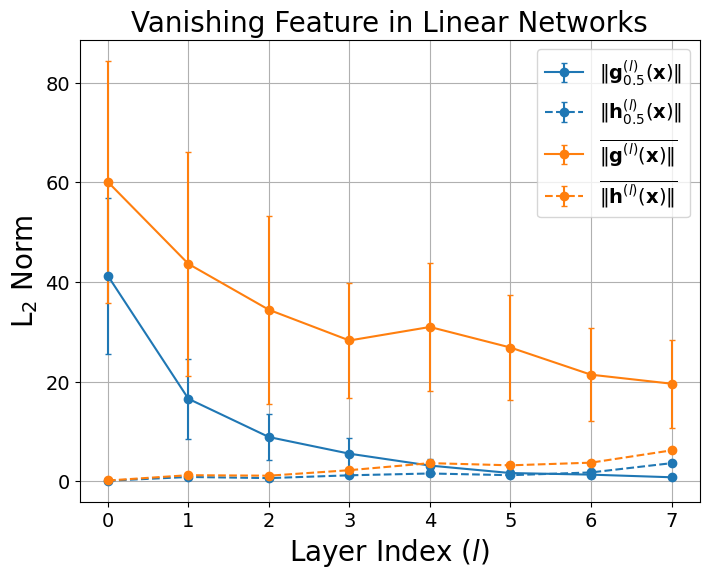

In [26]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

# Plot norm means with error bars for standard deviations
plt.errorbar(range(len(norm_means_weight_mid)), norm_means_weight_mid, yerr=norm_stds_weight_mid, fmt='-o', label=r'$\|\mathbf{g}^{(l)}_{0.5}(\mathbf{x})\|$', capsize=2, color='tab:blue')
plt.errorbar(range(len(norm_means_bias_mid)), norm_means_bias_mid, yerr=norm_stds_bias_mid, fmt='-o', label=r'$\|\mathbf{h}^{(l)}_{0.5}(\mathbf{x})\|$', capsize=2, color='tab:blue', linestyle='--')
plt.errorbar(range(len(norm_means_weight_end)), norm_means_weight_end, yerr=norm_stds_weight_end, fmt='-o', label=r'$\overline{\|\mathbf{g}^{(l)}(\mathbf{x})\|}$', capsize=2, color='tab:orange')
plt.errorbar(range(len(norm_means_bias_end)), norm_means_bias_end, yerr=norm_stds_bias_end, fmt='-o', label=r'$\overline{\|\mathbf{h}^{(l)}(\mathbf{x})\|}$', capsize=2, color='tab:orange', linestyle='--')

plt.xlabel(r'Layer Index ($l$)', fontsize=20)
plt.ylabel(r'L$_2$ Norm', fontsize=20)
plt.title('Vanishing Feature in Linear Networks', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

In [27]:
w_scale_1_s = []
b_scale_1_s = []
w_scale_2_s = []
b_scale_2_s = []
w_scale_mid_s = []
b_scale_mid_s = []

for i in range(num_layers):
    layer_1 = model_1.__getattr__(f'fc{i}')
    layer_2 = model_2.__getattr__(f'fc{i}')
    layer_test = model_test.__getattr__(f'fc{i}')

    w_scale_1 = layer_1.weight.abs().mean().item()
    b_scale_1 = layer_1.bias.abs().mean().item()
    w_scale_2 = layer_2.weight.abs().mean().item()
    b_scale_2 = layer_2.bias.abs().mean().item()
    w_scale_mid = layer_test.weight.abs().mean().item()
    b_scale_mid = layer_test.bias.abs().mean().item()
    
    
    w_scale_1_s.append(w_scale_1)
    b_scale_1_s.append(b_scale_1)
    w_scale_2_s.append(w_scale_2)
    b_scale_2_s.append(b_scale_2)
    w_scale_mid_s.append(w_scale_mid)
    b_scale_mid_s.append(b_scale_mid)

w_scale_1_s = np.array(w_scale_1_s)
b_scale_1_s = np.array(b_scale_1_s)
w_scale_2_s = np.array(w_scale_2_s)
b_scale_2_s = np.array(b_scale_2_s)
w_scale_mid_s = np.array(w_scale_mid_s)
b_scale_mid_s = np.array(b_scale_mid_s)

w_scale_end_s = (w_scale_1_s + w_scale_2_s) / 2
b_scale_end_s = (b_scale_1_s + b_scale_2_s) / 2



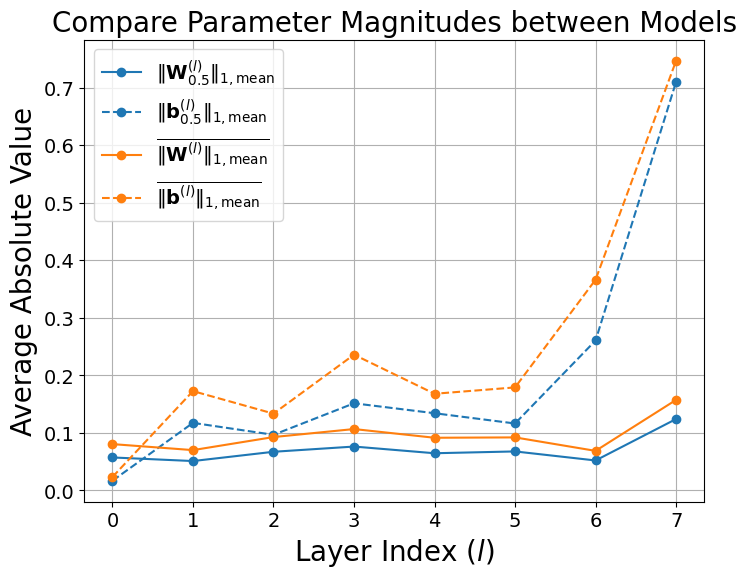

In [28]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

plt.plot(w_scale_mid_s, label=r'$\|\mathbf{W}^{(l)}_{0.5}\|_{1, \text{mean}}$', marker='o', color='tab:blue')
plt.plot(b_scale_mid_s, label=r'$\|\mathbf{b}^{(l)}_{0.5}\|_{1, \text{mean}}$', marker='o', color='tab:blue', linestyle='--')
plt.plot(w_scale_end_s, label=r'$\overline{\|\mathbf{W}^{(l)}\|_{1,\text{mean}}}$', marker='o', color='tab:orange')
plt.plot(b_scale_end_s, label=r'$\overline{\|\mathbf{b}^{(l)}\|_{1,\text{mean}}}$', marker='o', color='tab:orange', linestyle='--')

plt.xlabel(r'Layer Index ($l$)', fontsize=20)
plt.ylabel('Average Absolute Value', fontsize=20)
plt.title('Compare Parameter Magnitudes between Models', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

In [29]:
w_scale_means_diff = w_scale_end_s / w_scale_mid_s
w_scale_means_diff_prod = np.cumprod(w_scale_means_diff)

scaled_norm_means_weight_mid, scaled_norm_stds_weight_mid = [], []


for layer_idx in range(model_1.num_layers):
    internal_out_weight_mid = internal_weight_output(model_test, layer_idx, data)
    
    scaled_internal_out_weight_mid = internal_out_weight_mid * w_scale_means_diff_prod[layer_idx]
    norm_weight_mid = scaled_internal_out_weight_mid.norm(p=2, dim=1)
    scaled_norm_means_weight_mid.append(norm_weight_mid.mean(0).item())
    scaled_norm_stds_weight_mid.append(norm_weight_mid.std(0).item())
    
scaled_norm_means_weight_mid = np.array(scaled_norm_means_weight_mid)
scaled_norm_stds_weight_mid = np.array(scaled_norm_stds_weight_mid)


use norm instead of scale; but results are similar

/tmp/ipykernel_2625514/1865194331.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(range(len(scaled_norm_means_weight_mid)), scaled_norm_means_weight_mid,  yerr = scaled_norm_stds_weight_mid, fmt='-o', label=r'$\|\mathbf{g}^{(l)}_{0.5}(\mathbf{x})\|$'+', Scaled', capsize=2, color='tab:blue', linestyle='-.')


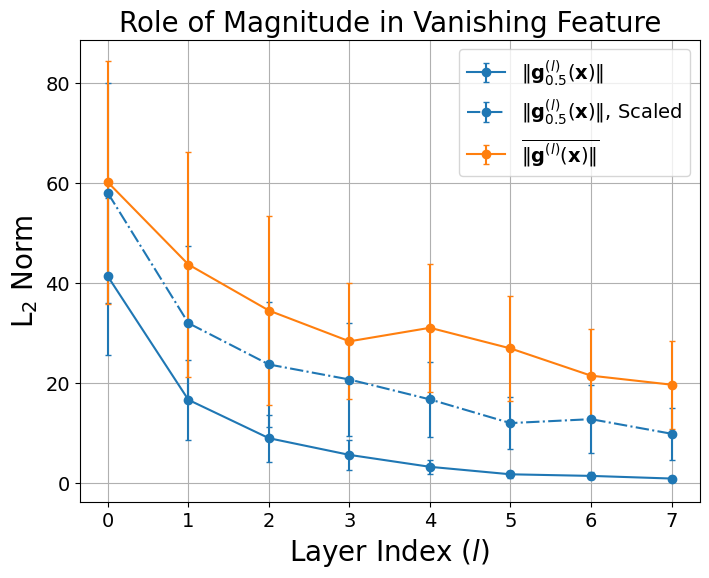

In [30]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

# Plot norm means with error bars for standard deviations
plt.errorbar(range(len(norm_means_weight_mid)), norm_means_weight_mid, yerr = norm_stds_weight_mid, fmt='-o', label=r'$\|\mathbf{g}^{(l)}_{0.5}(\mathbf{x})\|$', capsize=2, color='tab:blue')
plt.errorbar(range(len(scaled_norm_means_weight_mid)), scaled_norm_means_weight_mid,  yerr = scaled_norm_stds_weight_mid, fmt='-o', label=r'$\|\mathbf{g}^{(l)}_{0.5}(\mathbf{x})\|$'+', Scaled', capsize=2, color='tab:blue', linestyle='-.')
plt.errorbar(range(len(norm_means_weight_end)), norm_means_weight_end, fmt='-o',  yerr = norm_stds_weight_end, label=r'$\overline{\|\mathbf{g}^{(l)}(\mathbf{x})\|}$', capsize=2, color='tab:orange')

plt.xlabel(r'Layer Index ($l$)', fontsize=20)
plt.ylabel(r'L$_2$ Norm', fontsize=20)
plt.title(r'Role of Magnitude in Vanishing Feature', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()